In [1]:
!pip install transformers datasets scikit-learn matplotlib seaborn --quiet


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!pip install hf_transfer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 69.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
## LOADING DATA
import pandas as pd
import torch
from collections import Counter
# Path to your Sentiment140 CSV
path="training.1600000.processed.noemoticon.csv"

# Correct column names from dataset description
cols = ["sentiment", "id", "date", "flag", "user", "text"]

# Load CSV using correct encoding and no header
df = pd.read_csv(path, encoding="latin-1", header=None, names=cols)
# Keep only Positive (4) and Negative (0) sentiments
df = df[df['sentiment'].isin([0, 4])].reset_index(drop=True)
df['label'] = df['sentiment'].map({0: 0, 4: 1})

# Ensure balanced dataset
min_class_count = min(df['label'].value_counts()[0], df['label'].value_counts()[1])
pos_samples = df[df['label'] == 1].sample(min_class_count, random_state=42)
neg_samples = df[df['label'] == 0].sample(min_class_count, random_state=42)
balanced_df = pd.concat([pos_samples, neg_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

texts = balanced_df['text'].tolist()
labels = balanced_df['label'].tolist()

print(f"Total Sample Size: {len(texts)} (Balanced Positive, Negative)")

# Step 3: Tokenization and Data Preparation
from collections import Counter
from torch.utils.data import Dataset, DataLoader

tokenized_texts = [text.lower().split() for text in texts]
all_words = [word for text in tokenized_texts for word in text]
vocab = {word: idx + 1 for idx, (word, _) in enumerate(Counter(all_words).most_common(10000))}
vocab['<PAD>'] = 0

def encode(text, max_len=50):
    ids = [vocab.get(word, 0) for word in text]
    ids = ids[:max_len] + [0] * (max_len - len(ids))
    return ids

encoded_texts = [encode(text) for text in tokenized_texts]

# Balanced Split: 80% Train, 10% Validation, 10% Test
total_samples = len(encoded_texts)
train_end = int(0.8 * total_samples)
val_end = int(0.9 * total_samples)

X_train = encoded_texts[:train_end]
y_train = labels[:train_end]

X_val = encoded_texts[train_end:val_end]
y_val = labels[train_end:val_end]

X_test = encoded_texts[val_end:]
y_test = labels[val_end:]

print(f"Train Size: {len(X_train)}")
print(f"Validation Size: {len(X_val)}")
print(f"Test Size: {len(X_test)}")

class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
print(f"Using Batch Size: {batch_size}")

train_ds = SentimentDataset(X_train, y_train)
val_ds = SentimentDataset(X_val, y_val)
test_ds = SentimentDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

Total Sample Size: 1600000 (Balanced Positive, Negative)
Train Size: 1280000
Validation Size: 160000
Test Size: 160000
Using Batch Size: 32


In [4]:
# ================================
# MODIFIED CNN (supports all hyperparameters)
# ================================
import torch.nn as nn
import torch.nn.functional as F

class CNNModified(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, 
                 num_filters=128, kernel_size=5,
                 hidden_layers=1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # 3 conv layers (assignment requirement)
        self.conv1 = nn.Conv1d(embed_dim, num_filters, kernel_size)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size)
        self.conv3 = nn.Conv1d(num_filters, num_filters, kernel_size)

        # hidden layers (fully connected)
        self.hidden_fcs = nn.ModuleList()
        for _ in range(hidden_layers - 1):
            self.hidden_fcs.append(nn.Linear(num_filters, num_filters))

        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = self.pool(x).squeeze(2)

        for fc in self.hidden_fcs:
            x = F.relu(fc(x))

        x = self.fc(x).squeeze(1)
        return torch.sigmoid(x)


In [5]:
import time
import torch.nn as nn

def train_model(model, lr, optimizer_name="SGD"):
    model = model.to(device)
    criterion = nn.BCELoss()

    # Select optimizer
    optimizer = (torch.optim.SGD if optimizer_name == "SGD" 
                 else torch.optim.Adam)(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    patience = 3

    for epoch in range(1, 21):
        model.train()
        train_loss = 0.0
        total_batches = 0
        start = time.time()

        # -----------------------------
        # TRAINING LOOP (AVERAGED LOSS)
        # -----------------------------
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()      # accumulate batch-loss
            total_batches += 1

        avg_train_loss = train_loss / total_batches
        end = time.time()

        # -----------------------------
        # VALIDATION LOOP
        # -----------------------------
        model.eval()
        val_loss = 0.0
        val_batches = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                preds = model(X_batch)
                loss = criterion(preds, y_batch)

                val_loss += loss.item()
                val_batches += 1

                predicted = (preds > 0.5).int()
                correct += (predicted == y_batch.int()).sum().item()
                total += y_batch.size(0)

        avg_val_loss = val_loss / val_batches
        val_error_rate = 1 - (correct / total)

        # -----------------------------
        # PRINT LIKE BASELINE CNN
        # -----------------------------
        print(
            f"Epoch {epoch}, "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, "
            f"Val Error Rate: {val_error_rate*100:.2f}%, "
            f"Time: {end-start:.2f}s"
        )

        # -----------------------------
        # EARLY STOPPING
        # -----------------------------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = model.state_dict()
            patience = 3
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping triggered at epoch {epoch}.")
                break

    model.load_state_dict(best_state)
    return model


In [6]:
# Evaluation Function

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 7: Evaluation Function (Returns Accuracy)
def evaluate(model, loader, dataset_name="Test"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch)
            preds = (preds > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    total_error = (fp + fn) / len(all_labels)
    accuracy = 1 - total_error

    print(f"\n{dataset_name} Set Error Analysis:")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"False Positive Rate (FPR): {fpr:.2%}")
    print(f"False Negative Rate (FNR): {fnr:.2%}")
    print(f"Total Error Rate: {total_error:.2%}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['Negative', 'Positive'],
                 yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    return accuracy 


# Step 8: Count Parameters (YOUR EXACT FUNCTION)
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

In [7]:
# =================================================
# REBUILD DATASET FOR INPUT LENGTH EXPERIMENT
# =================================================

def rebuild_dataset(max_len):
    encoded = [encode(text, max_len=max_len) for text in tokenized_texts]

    X_train2 = encoded[:train_end]
    X_val2 = encoded[train_end:val_end]
    X_test2 = encoded[val_end:]

    train_loader2 = DataLoader(SentimentDataset(X_train2, y_train), batch_size=32, shuffle=True)
    val_loader2 = DataLoader(SentimentDataset(X_val2, y_val), batch_size=32)
    test_loader2 = DataLoader(SentimentDataset(X_test2, y_test), batch_size=32)

    return train_loader2, val_loader2, test_loader2



========== HYPERPARAMETER: LR = 0.01 ==========
Epoch 1, Train Loss: 0.5603, Val Loss: 0.4962, Val Error Rate: 24.29%, Time: 169.52s
Epoch 2, Train Loss: 0.4815, Val Loss: 0.4759, Val Error Rate: 23.12%, Time: 160.90s
Epoch 3, Train Loss: 0.4576, Val Loss: 0.4626, Val Error Rate: 22.13%, Time: 178.06s
Epoch 4, Train Loss: 0.4429, Val Loss: 0.4553, Val Error Rate: 21.68%, Time: 214.20s
Epoch 5, Train Loss: 0.4313, Val Loss: 0.4560, Val Error Rate: 21.68%, Time: 221.66s
Epoch 6, Train Loss: 0.4216, Val Loss: 0.4528, Val Error Rate: 21.38%, Time: 195.82s
Epoch 7, Train Loss: 0.4131, Val Loss: 0.4631, Val Error Rate: 21.70%, Time: 146.59s
Epoch 8, Train Loss: 0.4054, Val Loss: 0.4543, Val Error Rate: 21.27%, Time: 216.20s
Epoch 9, Train Loss: 0.3980, Val Loss: 0.4548, Val Error Rate: 21.45%, Time: 212.44s
Early stopping triggered at epoch 9.

Train LR=0.01 Set Error Analysis:
Accuracy: 83.26%
False Positive Rate (FPR): 17.60%
False Negative Rate (FNR): 15.88%
Total Error Rate: 16.74%


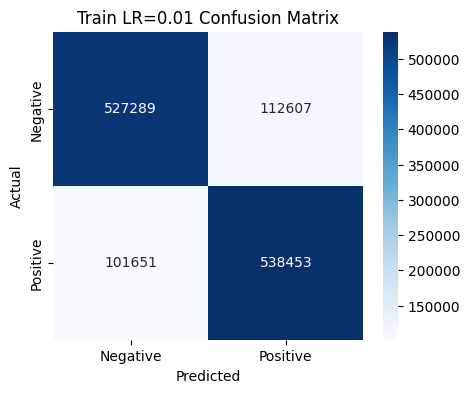


Val LR=0.01 Set Error Analysis:
Accuracy: 78.55%
False Positive Rate (FPR): 22.23%
False Negative Rate (FNR): 20.67%
Total Error Rate: 21.45%


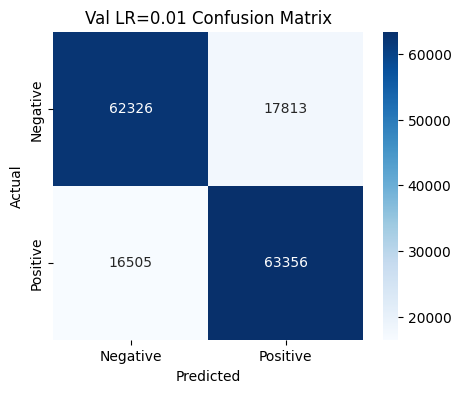


Test LR=0.01 Set Error Analysis:
Accuracy: 78.69%
False Positive Rate (FPR): 22.29%
False Negative Rate (FNR): 20.33%
Total Error Rate: 21.31%


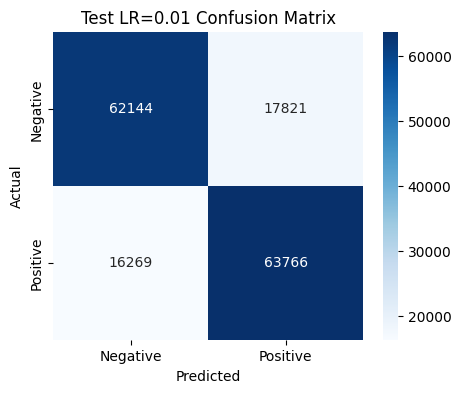


Model Parameters:
Total Parameters: 1,228,453
Trainable Parameters: 1,228,453

========== HYPERPARAMETER: LR = 0.1 ==========
Epoch 1, Train Loss: 0.5178, Val Loss: 0.4752, Val Error Rate: 23.00%, Time: 220.15s
Epoch 2, Train Loss: 0.4616, Val Loss: 0.4616, Val Error Rate: 22.04%, Time: 220.02s
Epoch 3, Train Loss: 0.4429, Val Loss: 0.4588, Val Error Rate: 21.36%, Time: 216.28s
Epoch 4, Train Loss: 0.4306, Val Loss: 0.4528, Val Error Rate: 21.10%, Time: 203.03s
Epoch 5, Train Loss: 0.4219, Val Loss: 0.4722, Val Error Rate: 22.22%, Time: 209.24s
Epoch 6, Train Loss: 0.4147, Val Loss: 0.4509, Val Error Rate: 20.81%, Time: 213.76s
Epoch 7, Train Loss: 0.4088, Val Loss: 0.4559, Val Error Rate: 20.96%, Time: 217.59s
Epoch 8, Train Loss: 0.4030, Val Loss: 0.4533, Val Error Rate: 21.02%, Time: 216.80s
Epoch 9, Train Loss: 0.3982, Val Loss: 0.4566, Val Error Rate: 20.95%, Time: 217.41s
Early stopping triggered at epoch 9.

Train LR=0.1 Set Error Analysis:
Accuracy: 83.64%
False Positive Rate 

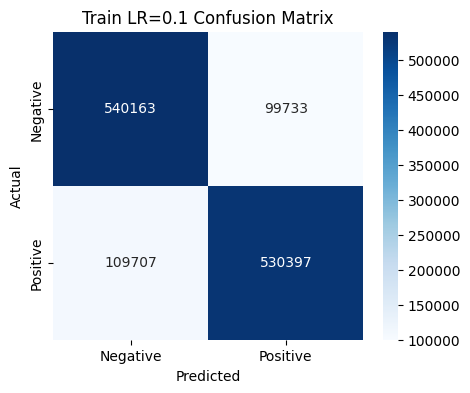


Val LR=0.1 Set Error Analysis:
Accuracy: 79.05%
False Positive Rate (FPR): 19.98%
False Negative Rate (FNR): 21.92%
Total Error Rate: 20.95%


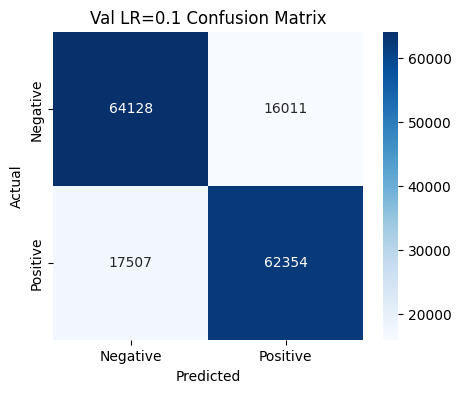


Test LR=0.1 Set Error Analysis:
Accuracy: 79.07%
False Positive Rate (FPR): 20.01%
False Negative Rate (FNR): 21.85%
Total Error Rate: 20.93%


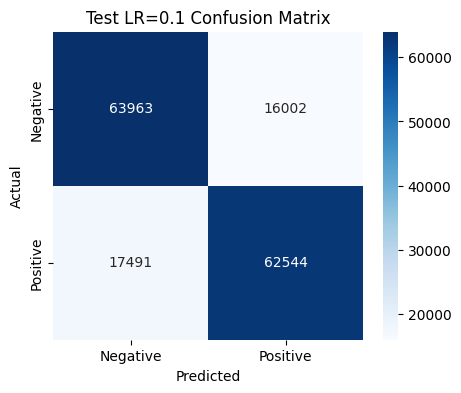


Model Parameters:
Total Parameters: 1,228,453
Trainable Parameters: 1,228,453

========== HYPERPARAMETER: OPTIMIZER = SGD ==========
Epoch 1, Train Loss: 0.5631, Val Loss: 0.5121, Val Error Rate: 25.66%, Time: 216.48s
Epoch 2, Train Loss: 0.4837, Val Loss: 0.4781, Val Error Rate: 23.16%, Time: 217.48s
Epoch 3, Train Loss: 0.4605, Val Loss: 0.4708, Val Error Rate: 22.57%, Time: 222.33s
Epoch 4, Train Loss: 0.4456, Val Loss: 0.4581, Val Error Rate: 21.83%, Time: 216.66s
Epoch 5, Train Loss: 0.4340, Val Loss: 0.4555, Val Error Rate: 21.67%, Time: 215.72s
Epoch 6, Train Loss: 0.4242, Val Loss: 0.4558, Val Error Rate: 21.57%, Time: 218.76s
Epoch 7, Train Loss: 0.4156, Val Loss: 0.4525, Val Error Rate: 21.49%, Time: 220.20s
Epoch 8, Train Loss: 0.4073, Val Loss: 0.4578, Val Error Rate: 21.57%, Time: 220.98s
Epoch 9, Train Loss: 0.3998, Val Loss: 0.4649, Val Error Rate: 21.84%, Time: 223.99s
Epoch 10, Train Loss: 0.3924, Val Loss: 0.4636, Val Error Rate: 21.77%, Time: 219.84s
Early stopping 

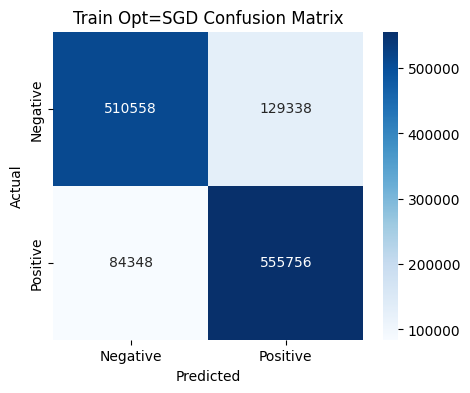


Val Opt=SGD Set Error Analysis:
Accuracy: 78.23%
False Positive Rate (FPR): 25.54%
False Negative Rate (FNR): 17.99%
Total Error Rate: 21.77%


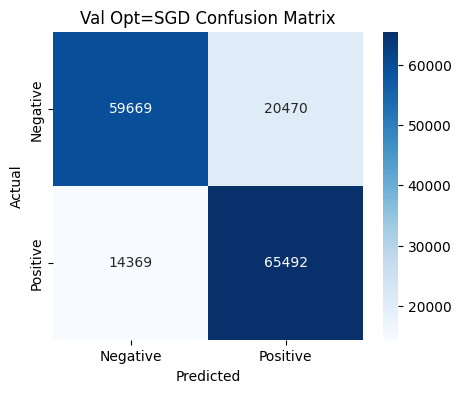


Test Opt=SGD Set Error Analysis:
Accuracy: 78.58%
False Positive Rate (FPR): 25.18%
False Negative Rate (FNR): 17.65%
Total Error Rate: 21.41%


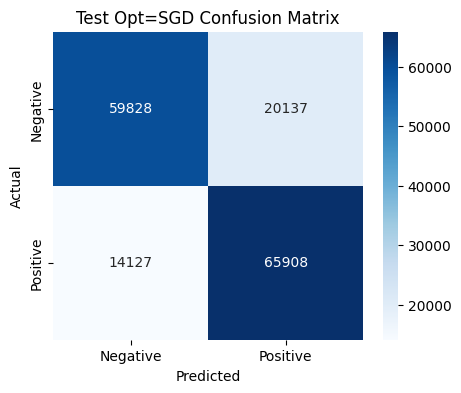


Model Parameters:
Total Parameters: 1,228,453
Trainable Parameters: 1,228,453

========== HYPERPARAMETER: OPTIMIZER = Adam ==========
Epoch 1, Train Loss: 0.5216, Val Loss: 0.5010, Val Error Rate: 23.01%, Time: 240.89s
Epoch 2, Train Loss: 0.5104, Val Loss: 0.4950, Val Error Rate: 21.43%, Time: 244.46s
Epoch 3, Train Loss: 0.4850, Val Loss: 0.4842, Val Error Rate: 22.57%, Time: 239.09s
Epoch 4, Train Loss: 0.4749, Val Loss: 0.4800, Val Error Rate: 21.68%, Time: 240.35s
Epoch 5, Train Loss: 0.4617, Val Loss: 0.4763, Val Error Rate: 21.37%, Time: 237.18s
Epoch 6, Train Loss: 0.5606, Val Loss: 0.6932, Val Error Rate: 50.09%, Time: 239.09s
Epoch 7, Train Loss: 0.6936, Val Loss: 0.6936, Val Error Rate: 50.09%, Time: 245.81s
Epoch 8, Train Loss: 0.6934, Val Loss: 0.6931, Val Error Rate: 49.91%, Time: 236.92s
Early stopping triggered at epoch 8.

Train Opt=Adam Set Error Analysis:
Accuracy: 49.99%
False Positive Rate (FPR): 0.00%
False Negative Rate (FNR): 100.00%
Total Error Rate: 50.01%


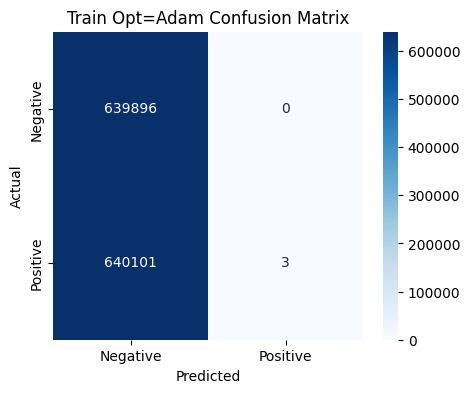


Val Opt=Adam Set Error Analysis:
Accuracy: 50.09%
False Positive Rate (FPR): 0.00%
False Negative Rate (FNR): 100.00%
Total Error Rate: 49.91%


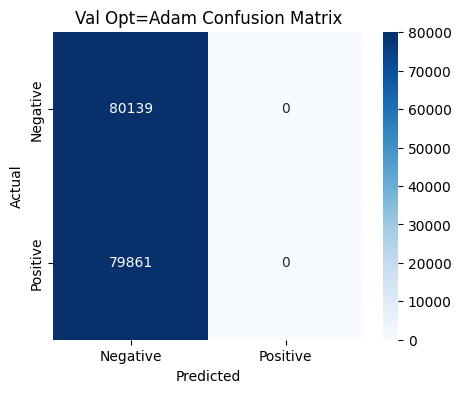


Test Opt=Adam Set Error Analysis:
Accuracy: 49.98%
False Positive Rate (FPR): 0.00%
False Negative Rate (FNR): 100.00%
Total Error Rate: 50.02%


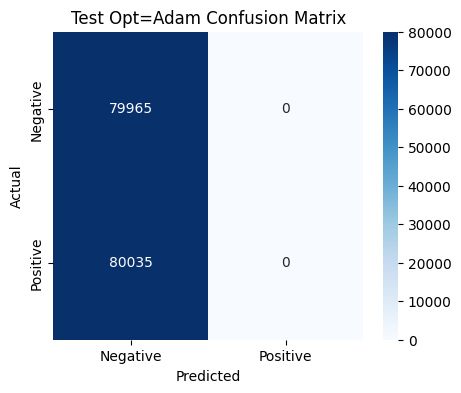


Model Parameters:
Total Parameters: 1,228,453
Trainable Parameters: 1,228,453

========== HYPERPARAMETER: Hidden Layers = 1 ==========
Epoch 1, Train Loss: 0.5615, Val Loss: 0.4998, Val Error Rate: 24.62%, Time: 210.20s
Epoch 2, Train Loss: 0.4838, Val Loss: 0.4759, Val Error Rate: 22.93%, Time: 211.09s
Epoch 3, Train Loss: 0.4605, Val Loss: 0.4655, Val Error Rate: 22.35%, Time: 218.87s
Epoch 4, Train Loss: 0.4451, Val Loss: 0.4588, Val Error Rate: 21.85%, Time: 207.03s
Epoch 5, Train Loss: 0.4337, Val Loss: 0.4663, Val Error Rate: 22.26%, Time: 212.96s
Epoch 6, Train Loss: 0.4240, Val Loss: 0.4529, Val Error Rate: 21.38%, Time: 215.80s
Epoch 7, Train Loss: 0.4152, Val Loss: 0.4527, Val Error Rate: 21.46%, Time: 205.63s
Epoch 8, Train Loss: 0.4074, Val Loss: 0.4539, Val Error Rate: 21.36%, Time: 216.55s
Epoch 9, Train Loss: 0.4000, Val Loss: 0.4531, Val Error Rate: 21.31%, Time: 220.05s
Epoch 10, Train Loss: 0.3928, Val Loss: 0.4586, Val Error Rate: 21.48%, Time: 215.21s
Early stoppin

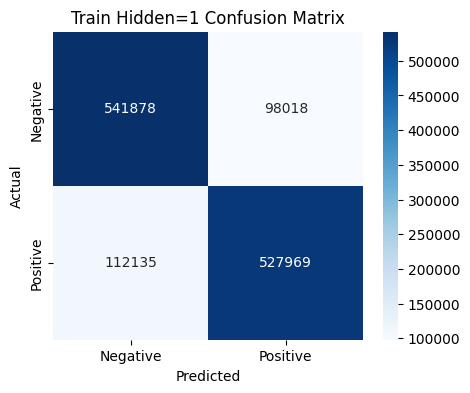


Val Hidden=1 Set Error Analysis:
Accuracy: 78.52%
False Positive Rate (FPR): 20.25%
False Negative Rate (FNR): 22.72%
Total Error Rate: 21.48%


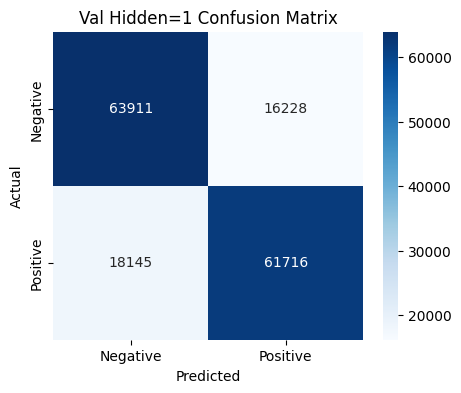


Test Hidden=1 Set Error Analysis:
Accuracy: 78.55%
False Positive Rate (FPR): 20.44%
False Negative Rate (FNR): 22.47%
Total Error Rate: 21.45%


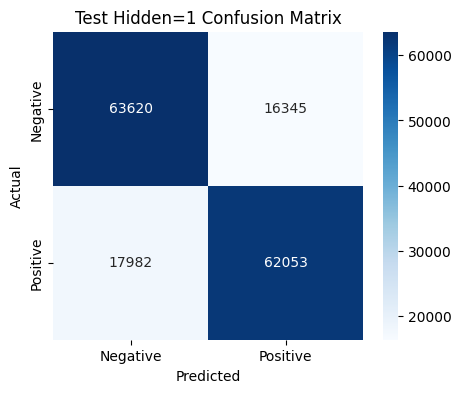


Model Parameters:
Total Parameters: 1,228,453
Trainable Parameters: 1,228,453

========== HYPERPARAMETER: Hidden Layers = 3 ==========
Epoch 1, Train Loss: 0.5976, Val Loss: 0.5068, Val Error Rate: 25.10%, Time: 259.33s
Epoch 2, Train Loss: 0.4900, Val Loss: 0.4755, Val Error Rate: 22.92%, Time: 255.91s
Epoch 3, Train Loss: 0.4621, Val Loss: 0.4652, Val Error Rate: 22.41%, Time: 257.72s
Epoch 4, Train Loss: 0.4456, Val Loss: 0.4581, Val Error Rate: 21.81%, Time: 259.59s
Epoch 5, Train Loss: 0.4332, Val Loss: 0.4614, Val Error Rate: 22.15%, Time: 256.58s
Epoch 6, Train Loss: 0.4228, Val Loss: 0.4542, Val Error Rate: 21.47%, Time: 256.66s
Epoch 7, Train Loss: 0.4137, Val Loss: 0.4518, Val Error Rate: 21.41%, Time: 251.34s
Epoch 8, Train Loss: 0.4054, Val Loss: 0.4545, Val Error Rate: 21.25%, Time: 255.78s
Epoch 9, Train Loss: 0.3976, Val Loss: 0.4548, Val Error Rate: 21.52%, Time: 248.69s
Epoch 10, Train Loss: 0.3899, Val Loss: 0.4568, Val Error Rate: 21.38%, Time: 253.32s
Early stoppin

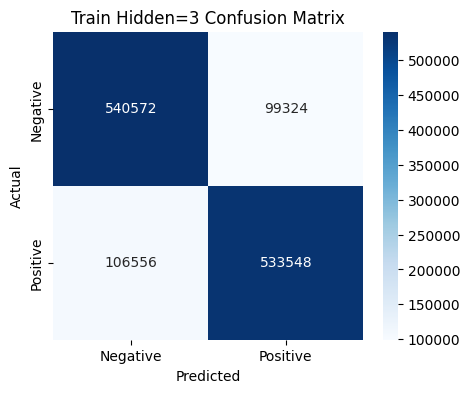


Val Hidden=3 Set Error Analysis:
Accuracy: 78.62%
False Positive Rate (FPR): 20.66%
False Negative Rate (FNR): 22.11%
Total Error Rate: 21.38%


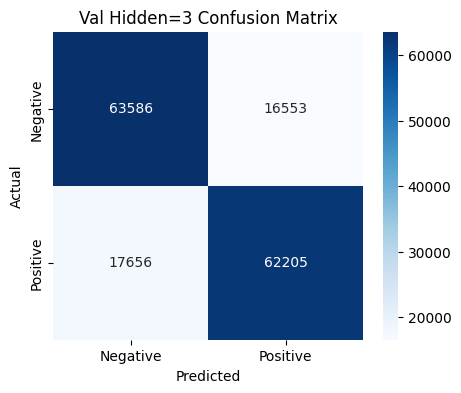


Test Hidden=3 Set Error Analysis:
Accuracy: 78.63%
False Positive Rate (FPR): 20.88%
False Negative Rate (FNR): 21.87%
Total Error Rate: 21.37%


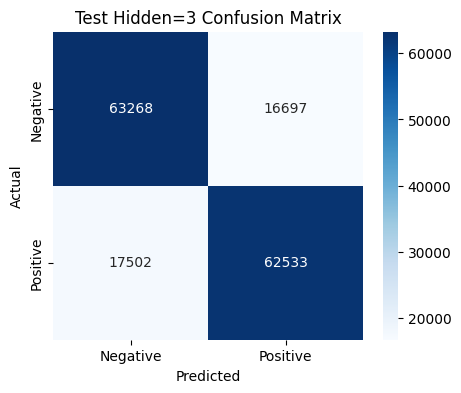


Model Parameters:
Total Parameters: 1,261,477
Trainable Parameters: 1,261,477

========== HYPERPARAMETER: Input Length = 50 ==========
Epoch 1, Train Loss: 0.5595, Val Loss: 0.5000, Val Error Rate: 24.60%, Time: 212.08s
Epoch 2, Train Loss: 0.4799, Val Loss: 0.4691, Val Error Rate: 22.58%, Time: 217.54s
Epoch 3, Train Loss: 0.4562, Val Loss: 0.4641, Val Error Rate: 22.30%, Time: 214.49s
Epoch 4, Train Loss: 0.4411, Val Loss: 0.4541, Val Error Rate: 21.61%, Time: 206.27s
Epoch 5, Train Loss: 0.4295, Val Loss: 0.4562, Val Error Rate: 21.64%, Time: 212.15s
Epoch 6, Train Loss: 0.4197, Val Loss: 0.4523, Val Error Rate: 21.42%, Time: 212.22s
Epoch 7, Train Loss: 0.4114, Val Loss: 0.4786, Val Error Rate: 22.82%, Time: 213.03s
Epoch 8, Train Loss: 0.4035, Val Loss: 0.4525, Val Error Rate: 21.36%, Time: 213.36s
Epoch 9, Train Loss: 0.3960, Val Loss: 0.4536, Val Error Rate: 21.30%, Time: 222.32s
Early stopping triggered at epoch 9.

Train Len=50 Set Error Analysis:
Accuracy: 83.32%
False Posit

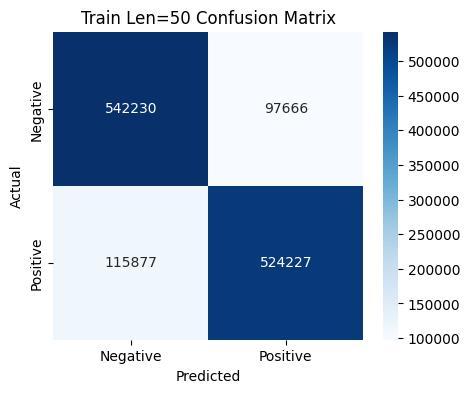


Val Len=50 Set Error Analysis:
Accuracy: 78.70%
False Positive Rate (FPR): 19.95%
False Negative Rate (FNR): 22.65%
Total Error Rate: 21.30%


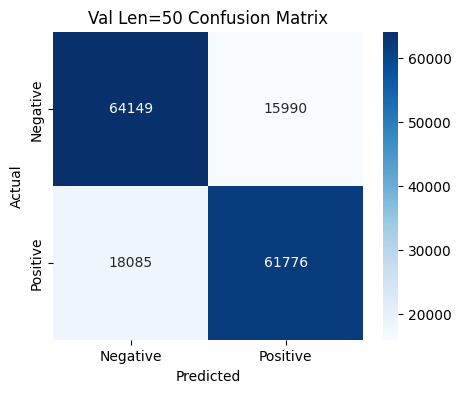


Test Len=50 Set Error Analysis:
Accuracy: 78.73%
False Positive Rate (FPR): 19.92%
False Negative Rate (FNR): 22.61%
Total Error Rate: 21.27%


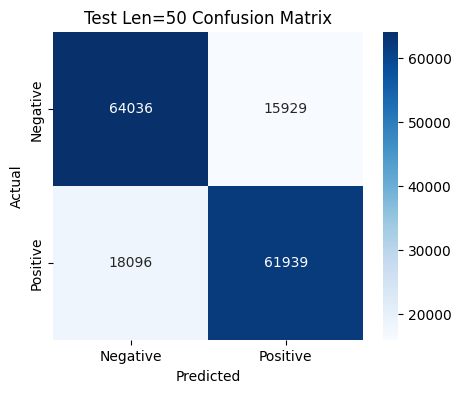


Model Parameters:
Total Parameters: 1,228,453
Trainable Parameters: 1,228,453

========== HYPERPARAMETER: Input Length = 250 ==========
Epoch 1, Train Loss: 0.5675, Val Loss: 0.4996, Val Error Rate: 24.57%, Time: 233.36s
Epoch 2, Train Loss: 0.4849, Val Loss: 0.4746, Val Error Rate: 23.02%, Time: 232.37s
Epoch 3, Train Loss: 0.4605, Val Loss: 0.4622, Val Error Rate: 22.08%, Time: 233.78s
Epoch 4, Train Loss: 0.4451, Val Loss: 0.4562, Val Error Rate: 21.67%, Time: 231.20s
Epoch 5, Train Loss: 0.4334, Val Loss: 0.4512, Val Error Rate: 21.32%, Time: 237.21s
Epoch 6, Train Loss: 0.4233, Val Loss: 0.4538, Val Error Rate: 21.44%, Time: 233.70s
Epoch 7, Train Loss: 0.4144, Val Loss: 0.4560, Val Error Rate: 21.58%, Time: 233.25s
Epoch 8, Train Loss: 0.4062, Val Loss: 0.4783, Val Error Rate: 22.63%, Time: 234.39s
Early stopping triggered at epoch 8.

Train Len=250 Set Error Analysis:
Accuracy: 81.04%
False Positive Rate (FPR): 28.87%
False Negative Rate (FNR): 9.06%
Total Error Rate: 18.96%


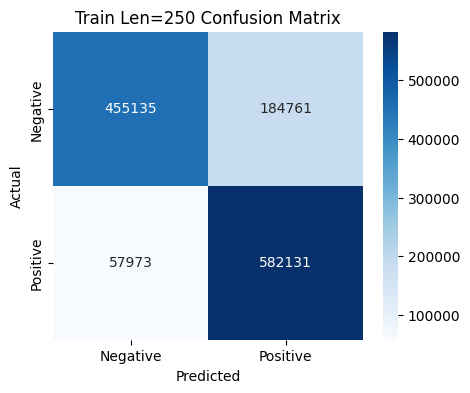


Val Len=250 Set Error Analysis:
Accuracy: 77.37%
False Positive Rate (FPR): 32.65%
False Negative Rate (FNR): 12.58%
Total Error Rate: 22.63%


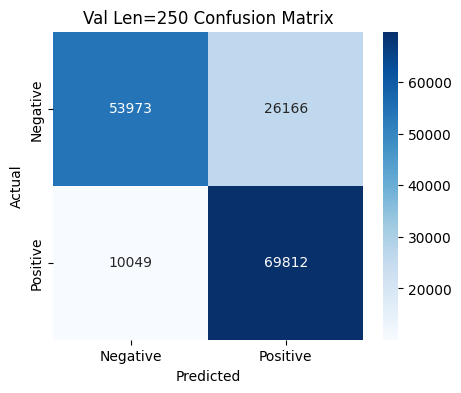


Test Len=250 Set Error Analysis:
Accuracy: 77.48%
False Positive Rate (FPR): 32.73%
False Negative Rate (FNR): 12.33%
Total Error Rate: 22.53%


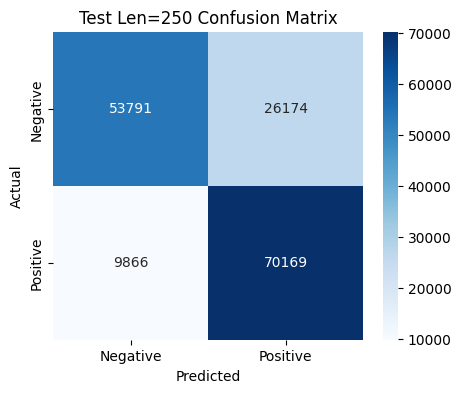


Model Parameters:
Total Parameters: 1,228,453
Trainable Parameters: 1,228,453

========== HYPERPARAMETER: Kernel Size = 5 ==========
Epoch 1, Train Loss: 0.5603, Val Loss: 0.4971, Val Error Rate: 24.48%, Time: 234.17s
Epoch 2, Train Loss: 0.4828, Val Loss: 0.4737, Val Error Rate: 22.82%, Time: 236.64s
Epoch 3, Train Loss: 0.4594, Val Loss: 0.4632, Val Error Rate: 22.16%, Time: 238.08s
Epoch 4, Train Loss: 0.4444, Val Loss: 0.4580, Val Error Rate: 21.86%, Time: 236.81s
Epoch 5, Train Loss: 0.4329, Val Loss: 0.4619, Val Error Rate: 22.02%, Time: 233.08s
Epoch 6, Train Loss: 0.4231, Val Loss: 0.4581, Val Error Rate: 21.70%, Time: 230.45s
Epoch 7, Train Loss: 0.4146, Val Loss: 0.4503, Val Error Rate: 21.21%, Time: 234.48s
Epoch 8, Train Loss: 0.4068, Val Loss: 0.4563, Val Error Rate: 21.72%, Time: 237.28s
Epoch 9, Train Loss: 0.3993, Val Loss: 0.4604, Val Error Rate: 21.61%, Time: 237.24s
Epoch 10, Train Loss: 0.3921, Val Loss: 0.4570, Val Error Rate: 21.41%, Time: 235.62s
Early stopping 

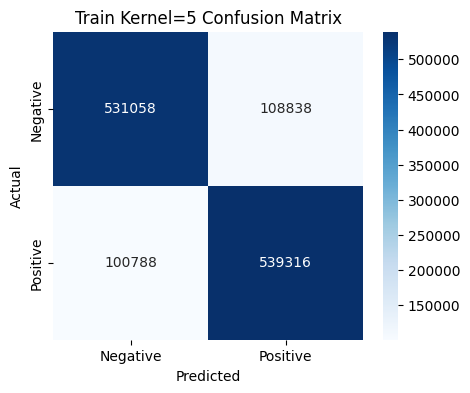


Val Kernel=5 Set Error Analysis:
Accuracy: 78.59%
False Positive Rate (FPR): 22.00%
False Negative Rate (FNR): 20.81%
Total Error Rate: 21.41%


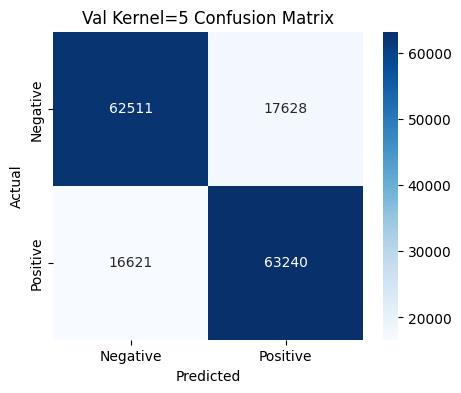


Test Kernel=5 Set Error Analysis:
Accuracy: 78.57%
False Positive Rate (FPR): 21.99%
False Negative Rate (FNR): 20.87%
Total Error Rate: 21.43%


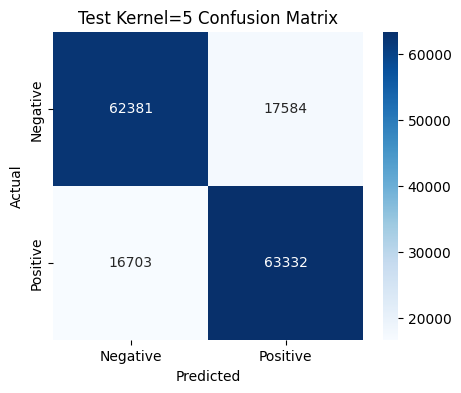


Model Parameters:
Total Parameters: 1,228,453
Trainable Parameters: 1,228,453

========== HYPERPARAMETER: Kernel Size = 25 ==========
Epoch 1, Train Loss: 0.6183, Val Loss: 0.5639, Val Error Rate: 29.76%, Time: 234.75s
Epoch 2, Train Loss: 0.5438, Val Loss: 0.5218, Val Error Rate: 26.44%, Time: 232.08s
Epoch 3, Train Loss: 0.5068, Val Loss: 0.5000, Val Error Rate: 24.71%, Time: 234.73s
Epoch 4, Train Loss: 0.4783, Val Loss: 0.4893, Val Error Rate: 23.91%, Time: 232.76s
Epoch 5, Train Loss: 0.4543, Val Loss: 0.4807, Val Error Rate: 23.23%, Time: 233.56s
Epoch 6, Train Loss: 0.4340, Val Loss: 0.4753, Val Error Rate: 22.91%, Time: 233.86s
Epoch 7, Train Loss: 0.4163, Val Loss: 0.4753, Val Error Rate: 22.49%, Time: 237.01s
Epoch 8, Train Loss: 0.4004, Val Loss: 0.4826, Val Error Rate: 22.62%, Time: 236.56s
Epoch 9, Train Loss: 0.3853, Val Loss: 0.5092, Val Error Rate: 23.56%, Time: 239.17s
Epoch 10, Train Loss: 0.3706, Val Loss: 0.5129, Val Error Rate: 23.51%, Time: 241.08s
Early stopping

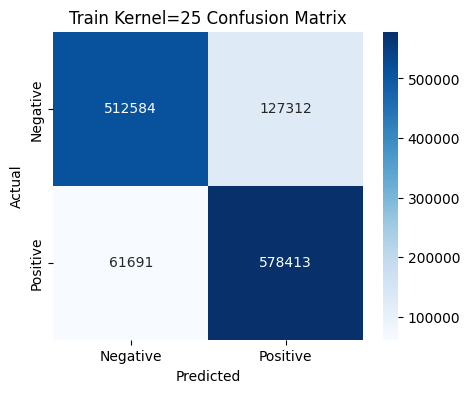


Val Kernel=25 Set Error Analysis:
Accuracy: 76.49%
False Positive Rate (FPR): 29.11%
False Negative Rate (FNR): 17.88%
Total Error Rate: 23.51%


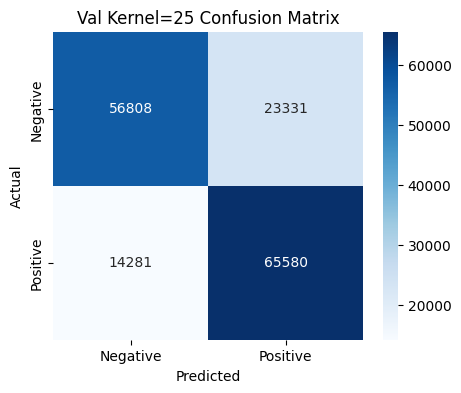


Test Kernel=25 Set Error Analysis:
Accuracy: 76.64%
False Positive Rate (FPR): 29.15%
False Negative Rate (FNR): 17.58%
Total Error Rate: 23.36%


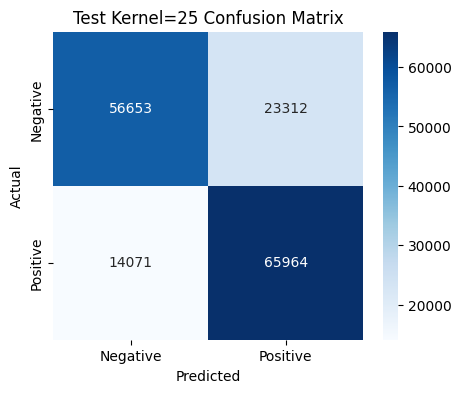


Model Parameters:
Total Parameters: 2,139,813
Trainable Parameters: 2,139,813

========== HYPERPARAMETER: Embedding Dimension = 100 ==========
Epoch 1, Train Loss: 0.5659, Val Loss: 0.5008, Val Error Rate: 24.63%, Time: 234.34s
Epoch 2, Train Loss: 0.4835, Val Loss: 0.4745, Val Error Rate: 22.84%, Time: 234.25s
Epoch 3, Train Loss: 0.4595, Val Loss: 0.4678, Val Error Rate: 22.58%, Time: 234.64s
Epoch 4, Train Loss: 0.4445, Val Loss: 0.4567, Val Error Rate: 21.76%, Time: 235.22s
Epoch 5, Train Loss: 0.4328, Val Loss: 0.4542, Val Error Rate: 21.69%, Time: 233.95s
Epoch 6, Train Loss: 0.4230, Val Loss: 0.4523, Val Error Rate: 21.60%, Time: 232.45s
Epoch 7, Train Loss: 0.4143, Val Loss: 0.4582, Val Error Rate: 21.60%, Time: 234.95s
Epoch 8, Train Loss: 0.4063, Val Loss: 0.4498, Val Error Rate: 21.41%, Time: 244.29s
Epoch 9, Train Loss: 0.3989, Val Loss: 0.4541, Val Error Rate: 21.41%, Time: 242.46s
Epoch 10, Train Loss: 0.3917, Val Loss: 0.4545, Val Error Rate: 21.40%, Time: 234.42s
Epoch

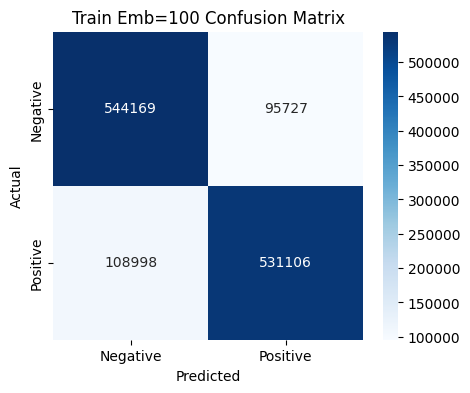


Val Emb=100 Set Error Analysis:
Accuracy: 78.42%
False Positive Rate (FPR): 20.34%
False Negative Rate (FNR): 22.82%
Total Error Rate: 21.58%


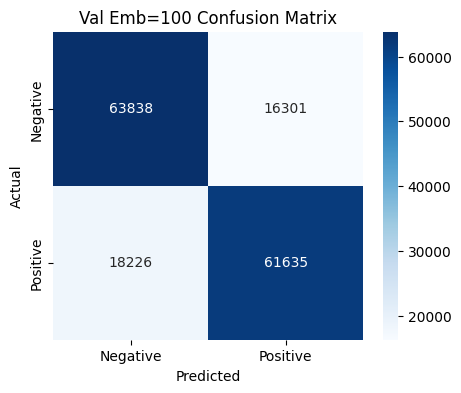


Test Emb=100 Set Error Analysis:
Accuracy: 78.57%
False Positive Rate (FPR): 20.44%
False Negative Rate (FNR): 22.42%
Total Error Rate: 21.43%


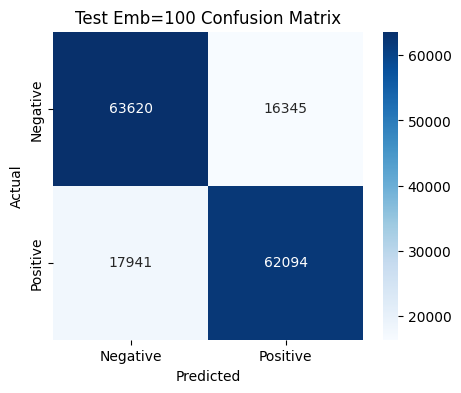


Model Parameters:
Total Parameters: 1,228,453
Trainable Parameters: 1,228,453

========== HYPERPARAMETER: Embedding Dimension = 500 ==========
Epoch 1, Train Loss: 0.5163, Val Loss: 0.4626, Val Error Rate: 22.06%, Time: 242.68s
Epoch 2, Train Loss: 0.4434, Val Loss: 0.4416, Val Error Rate: 20.77%, Time: 238.55s
Epoch 3, Train Loss: 0.4159, Val Loss: 0.4333, Val Error Rate: 20.20%, Time: 240.30s
Epoch 4, Train Loss: 0.3967, Val Loss: 0.4318, Val Error Rate: 19.89%, Time: 240.02s
Epoch 5, Train Loss: 0.3810, Val Loss: 0.4293, Val Error Rate: 19.90%, Time: 234.79s
Epoch 6, Train Loss: 0.3665, Val Loss: 0.4367, Val Error Rate: 20.03%, Time: 234.41s
Epoch 7, Train Loss: 0.3532, Val Loss: 0.4383, Val Error Rate: 20.04%, Time: 226.59s
Epoch 8, Train Loss: 0.3407, Val Loss: 0.4540, Val Error Rate: 20.54%, Time: 232.53s
Early stopping triggered at epoch 8.

Train Emb=500 Set Error Analysis:
Accuracy: 86.27%
False Positive Rate (FPR): 9.25%
False Negative Rate (FNR): 18.22%
Total Error Rate: 13

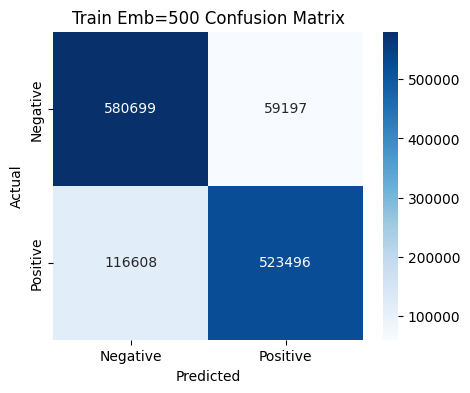


Val Emb=500 Set Error Analysis:
Accuracy: 79.46%
False Positive Rate (FPR): 15.78%
False Negative Rate (FNR): 25.32%
Total Error Rate: 20.54%


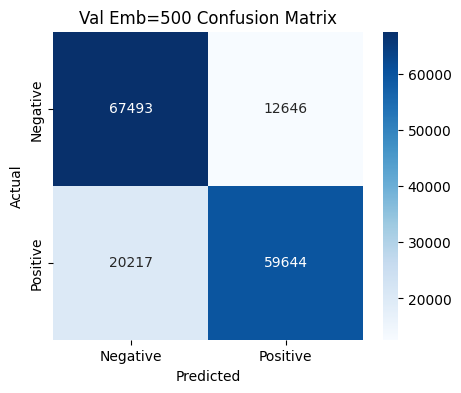


Test Emb=500 Set Error Analysis:
Accuracy: 79.54%
False Positive Rate (FPR): 15.75%
False Negative Rate (FNR): 25.16%
Total Error Rate: 20.46%


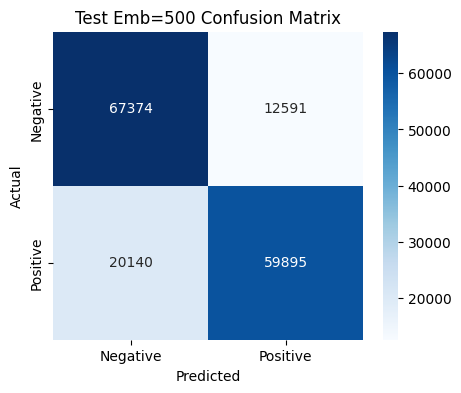


Model Parameters:
Total Parameters: 5,484,853
Trainable Parameters: 5,484,853

==================== FINAL HYPERPARAMETER RESULTS ====================

         Experiment Setting  Train Accuracy  Validation Accuracy  Test Accuracy
      Learning Rate    0.01        0.832611             0.785513       0.786938
      Learning Rate     0.1        0.836375             0.790512       0.790669
          Optimizer     SGD        0.833058             0.782256       0.785850
          Optimizer    Adam        0.499921             0.500869       0.499781
      Hidden Layers       1        0.835818             0.785169       0.785456
      Hidden Layers       3        0.839156             0.786194       0.786256
       Input Length      50        0.833170             0.787031       0.787344
       Input Length     250        0.810364             0.773656       0.774750
        Kernel Size       5        0.836230             0.785944       0.785706
        Kernel Size      25        0.852341     

In [8]:
# ================================
# RUN ALL HYPERPARAMETER EXPERIMENTS
# ================================

results = []

# 1. Learning Rate Experiments
for lr in [0.01, 0.1]:
    print(f"\n========== HYPERPARAMETER: LR = {lr} ==========")

    model = CNNModified(len(vocab))
    model = train_model(model, lr)   # DO NOT MODIFY train_model

    train_acc = evaluate(model, train_loader, dataset_name=f"Train LR={lr}")
    val_acc   = evaluate(model, val_loader, dataset_name=f"Val LR={lr}")
    test_acc  = evaluate(model, test_loader, dataset_name=f"Test LR={lr}")

    print("\nModel Parameters:")
    count_parameters(model)

    results.append({
        "Experiment": "Learning Rate",
        "Setting": lr,
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc
    })


# 2. Optimizer Experiments (SGD vs Adam)
for opt in ["SGD", "Adam"]:
    print(f"\n========== HYPERPARAMETER: OPTIMIZER = {opt} ==========")

    model = CNNModified(len(vocab))

    # override optimizer in train_model
    model = train_model(model, lr=0.01, optimizer_name=opt)

    train_acc = evaluate(model, train_loader, dataset_name=f"Train Opt={opt}")
    val_acc   = evaluate(model, val_loader, dataset_name=f"Val Opt={opt}")
    test_acc  = evaluate(model, test_loader, dataset_name=f"Test Opt={opt}")

    print("\nModel Parameters:")
    count_parameters(model)

    results.append({
        "Experiment": "Optimizer",
        "Setting": opt,
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc
    })


# 3. Hidden Layer Experiments (1 vs 3)
for h in [1, 3]:
    print(f"\n========== HYPERPARAMETER: Hidden Layers = {h} ==========")

    model = CNNModified(len(vocab), hidden_layers=h)
    model = train_model(model, lr=0.01)

    train_acc = evaluate(model, train_loader, dataset_name=f"Train Hidden={h}")
    val_acc   = evaluate(model, val_loader, dataset_name=f"Val Hidden={h}")
    test_acc  = evaluate(model, test_loader, dataset_name=f"Test Hidden={h}")

    print("\nModel Parameters:")
    count_parameters(model)

    results.append({
        "Experiment": "Hidden Layers",
        "Setting": h,
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc
    })


# 4. Input Length (50 vs 250)
for L in [50, 250]:
    print(f"\n========== HYPERPARAMETER: Input Length = {L} ==========")

    train_loader, val_loader, test_loader = rebuild_dataset(L)

    model = CNNModified(len(vocab))
    model = train_model(model, lr=0.01)

    train_acc = evaluate(model, train_loader, dataset_name=f"Train Len={L}")
    val_acc   = evaluate(model, val_loader, dataset_name=f"Val Len={L}")
    test_acc  = evaluate(model, test_loader, dataset_name=f"Test Len={L}")

    print("\nModel Parameters:")
    count_parameters(model)

    results.append({
        "Experiment": "Input Length",
        "Setting": L,
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc
    })


# 5. Kernel Size (5 vs 25)
for k in [5, 25]:
    print(f"\n========== HYPERPARAMETER: Kernel Size = {k} ==========")

    model = CNNModified(len(vocab), kernel_size=k)
    model = train_model(model, lr=0.01)

    train_acc = evaluate(model, train_loader, dataset_name=f"Train Kernel={k}")
    val_acc   = evaluate(model, val_loader, dataset_name=f"Val Kernel={k}")
    test_acc  = evaluate(model, test_loader, dataset_name=f"Test Kernel={k}")

    print("\nModel Parameters:")
    count_parameters(model)

    results.append({
        "Experiment": "Kernel Size",
        "Setting": k,
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc
    })


# 6. Embedding Dimension (100 vs 500)
for emb in [100, 500]:
    print(f"\n========== HYPERPARAMETER: Embedding Dimension = {emb} ==========")

    model = CNNModified(len(vocab), embed_dim=emb)
    model = train_model(model, lr=0.01)

    train_acc = evaluate(model, train_loader, dataset_name=f"Train Emb={emb}")
    val_acc   = evaluate(model, val_loader, dataset_name=f"Val Emb={emb}")
    test_acc  = evaluate(model, test_loader, dataset_name=f"Test Emb={emb}")

    print("\nModel Parameters:")
    count_parameters(model)

    results.append({
        "Experiment": "Embedding Dimension",
        "Setting": emb,
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc
    })


# Final Results Table
df_results = pd.DataFrame(results)
print("\n==================== FINAL HYPERPARAMETER RESULTS ====================\n")
print(df_results.to_string(index=False))



========== HYPERPARAMETER: Kernel Size = 3 ==========
Epoch 1, Train Loss: 0.5494, Val Loss: 0.4915, Val Error Rate: 23.94%, Time: 230.43s
Epoch 2, Train Loss: 0.4744, Val Loss: 0.4648, Val Error Rate: 22.30%, Time: 231.48s
Epoch 3, Train Loss: 0.4533, Val Loss: 0.4598, Val Error Rate: 21.96%, Time: 229.75s
Epoch 4, Train Loss: 0.4403, Val Loss: 0.4487, Val Error Rate: 21.21%, Time: 227.28s
Epoch 5, Train Loss: 0.4302, Val Loss: 0.4495, Val Error Rate: 21.25%, Time: 224.59s
Epoch 6, Train Loss: 0.4222, Val Loss: 0.4444, Val Error Rate: 20.81%, Time: 233.53s
Epoch 7, Train Loss: 0.4151, Val Loss: 0.4410, Val Error Rate: 20.77%, Time: 235.68s
Epoch 8, Train Loss: 0.4087, Val Loss: 0.4473, Val Error Rate: 21.04%, Time: 232.29s
Epoch 9, Train Loss: 0.4031, Val Loss: 0.4437, Val Error Rate: 20.77%, Time: 232.90s
Epoch 10, Train Loss: 0.3978, Val Loss: 0.4442, Val Error Rate: 20.77%, Time: 231.17s
Early stopping triggered at epoch 10.

Train Kernel=3 Set Error Analysis:
Accuracy: 82.76%
Fal

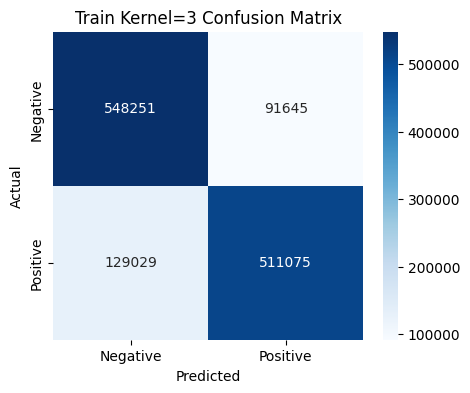


Val Kernel=3 Set Error Analysis:
Accuracy: 79.23%
False Positive Rate (FPR): 17.74%
False Negative Rate (FNR): 23.80%
Total Error Rate: 20.77%


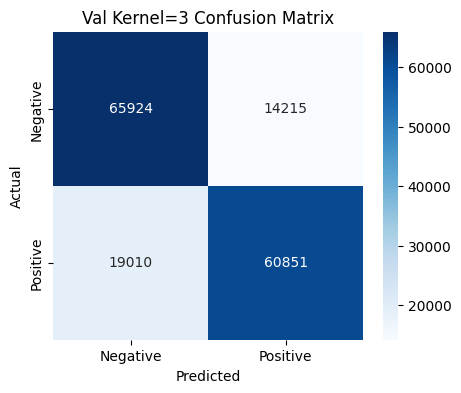


Test Kernel=3 Set Error Analysis:
Accuracy: 79.12%
False Positive Rate (FPR): 17.90%
False Negative Rate (FNR): 23.86%
Total Error Rate: 20.88%


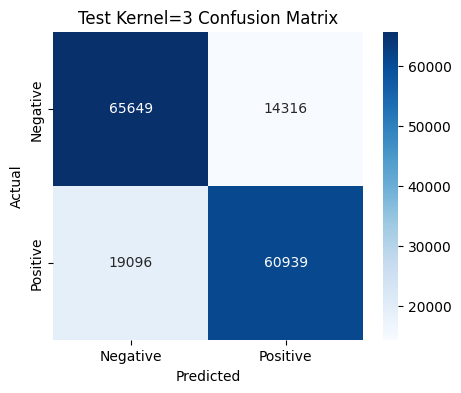


Model Parameters:
Total Parameters: 1,137,317
Trainable Parameters: 1,137,317


In [10]:
    k=3
    print(f"\n========== HYPERPARAMETER: Kernel Size = {k} ==========")

    model = CNNModified(len(vocab), kernel_size=k)
    model = train_model(model, lr=0.01)

    train_acc = evaluate(model, train_loader, dataset_name=f"Train Kernel={k}")
    val_acc   = evaluate(model, val_loader, dataset_name=f"Val Kernel={k}")
    test_acc  = evaluate(model, test_loader, dataset_name=f"Test Kernel={k}")

    print("\nModel Parameters:")
    count_parameters(model)

    results.append({
        "Experiment": "Kernel Size",
        "Setting": k,
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc
    })


In [11]:
# Final Results Table
df_results = pd.DataFrame(results)
print("\n==================== FINAL HYPERPARAMETER RESULTS ====================\n")
print(df_results.to_string(index=False))


==================== FINAL HYPERPARAMETER RESULTS ====================

         Experiment Setting  Train Accuracy  Validation Accuracy  Test Accuracy
      Learning Rate    0.01        0.832611             0.785513       0.786938
      Learning Rate     0.1        0.836375             0.790512       0.790669
          Optimizer     SGD        0.833058             0.782256       0.785850
          Optimizer    Adam        0.499921             0.500869       0.499781
      Hidden Layers       1        0.835818             0.785169       0.785456
      Hidden Layers       3        0.839156             0.786194       0.786256
       Input Length      50        0.833170             0.787031       0.787344
       Input Length     250        0.810364             0.773656       0.774750
        Kernel Size       5        0.836230             0.785944       0.785706
        Kernel Size      25        0.852341             0.764925       0.766356
Embedding Dimension     100        0.840059    